In [1]:
from collections import Counter

import chess.pgn


def analyze_pgn(pgn_file_path, max_games=None):
    # Initialize variables
    total_games = 0
    white_wins = 0
    black_wins = 0
    ties = 0
    game_durations_moves = []
    game_durations_time = []
    rating_differences = []
    results = []
    white_ratings = []
    black_ratings = []
    time_controls = []
    openings = Counter()

    # Open the PGN file
    with open(pgn_file_path) as pgn_file:
        while max_games is None or max_games > total_games:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break

            total_games += 1

            # Get result
            result = game.headers.get("Result", "*")
            if result == "1-0":
                white_wins += 1
                results.append(1)
            elif result == "0-1":
                black_wins += 1
                results.append(0)
            else:
                ties += 1
                results.append(0.5)

            # Get game duration in moves
            moves = list(game.mainline_moves())
            game_durations_moves.append(len(moves))

            # Get game duration in time (if available)
            time_control = game.headers.get("TimeControl")
            if time_control:
                time_controls.append(time_control)
                if "+" in time_control:
                    initial_time, increment = map(int, time_control.split("+"))
                    total_time = initial_time + (len(moves) * increment)
                    game_durations_time.append(total_time)

            # Get ratings and rating difference
            white_elo = game.headers.get("WhiteElo")
            black_elo = game.headers.get("BlackElo")
            if white_elo:
                white_elo = int(white_elo)
                white_ratings.append(white_elo)
            if black_elo:
                black_elo = int(black_elo)
                black_ratings.append(black_elo)
            if white_elo and black_elo:
                rating_diff = white_elo - black_elo
                rating_differences.append(rating_diff)

            opening = game.headers.get("Opening", "Unknown")
            openings[opening] += 1

    return {
        "total_games": total_games,
        "white_wins": white_wins,
        "black_wins": black_wins,
        "ties": ties,
        "game_durations_moves": game_durations_moves,
        "game_durations_time": game_durations_time,
        "rating_differences": rating_differences,
        "results": results,
        "white_ratings": white_ratings,
        "black_ratings": black_ratings,
        "time_controls": time_controls,
        "openings": dict(openings)
    }


In [3]:
# Example usage
pgn_file_path = "../data/lichess_db_standard_rated_2017-01.pgn/lichess_db_standard_rated_2017-01.pgn"
game_sts = analyze_pgn(pgn_file_path, 10000)

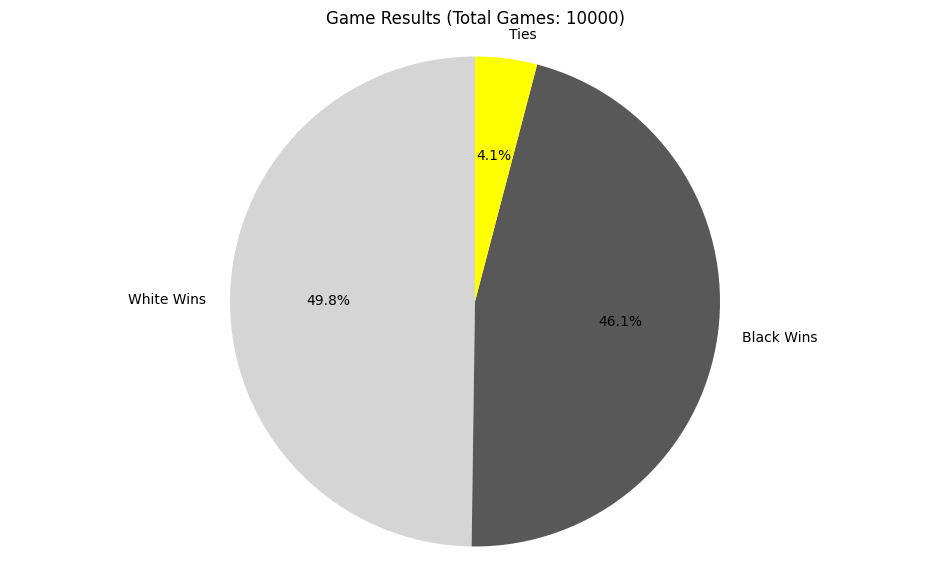

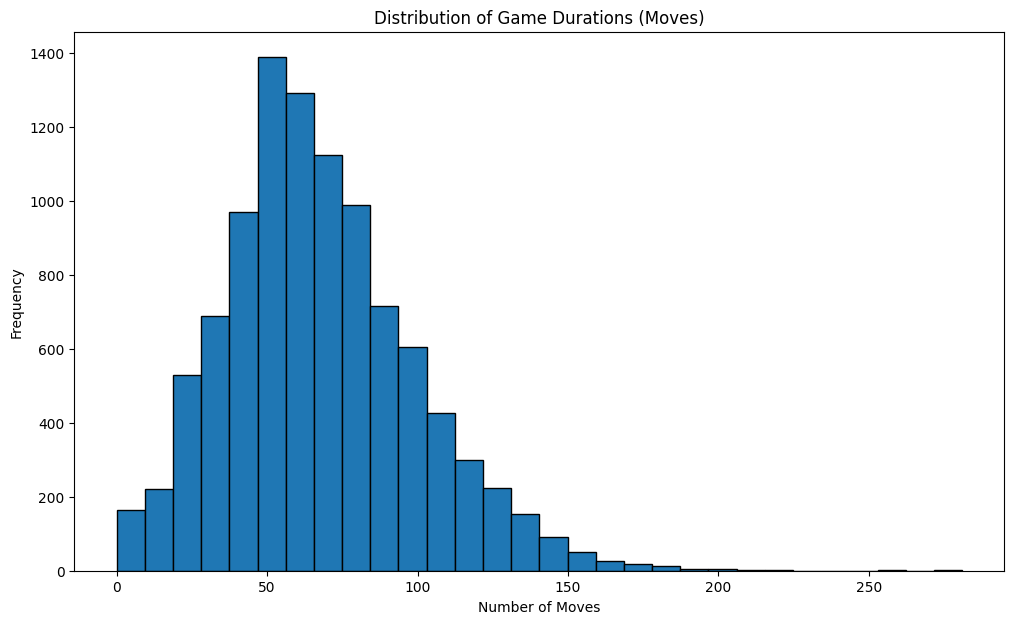

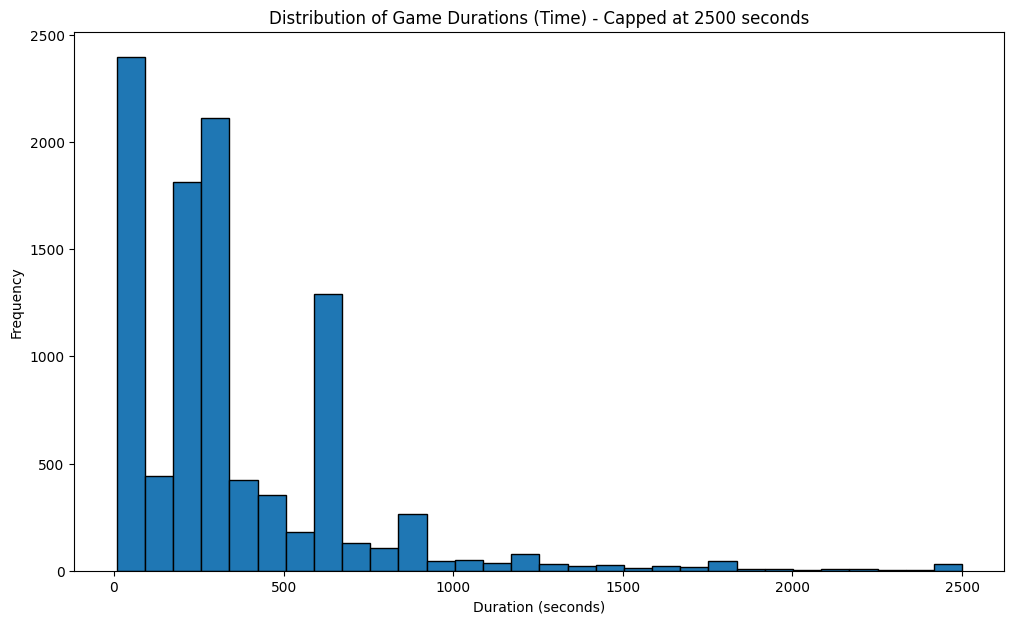

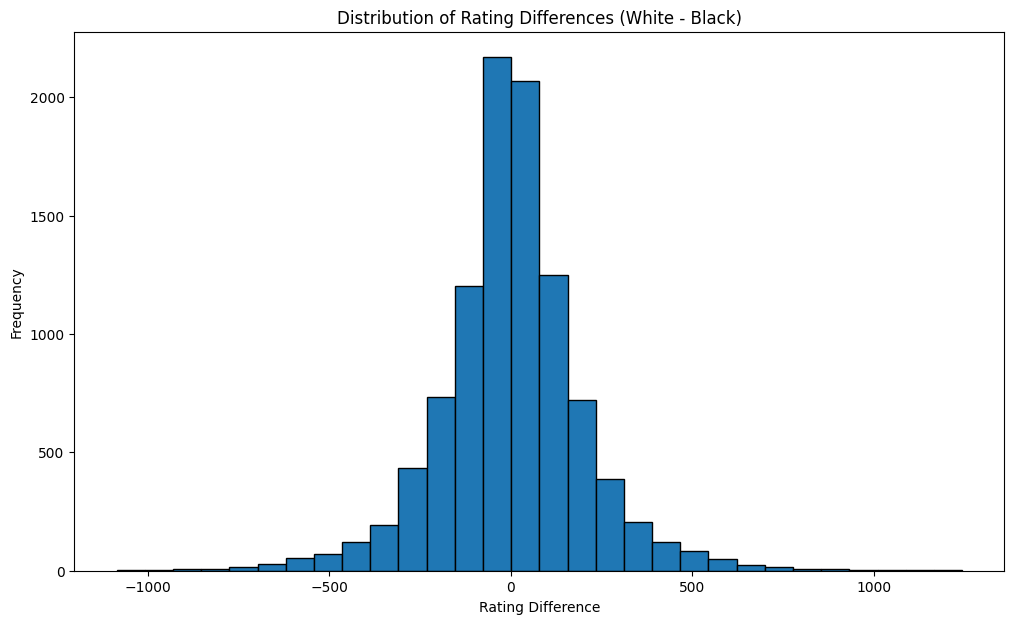

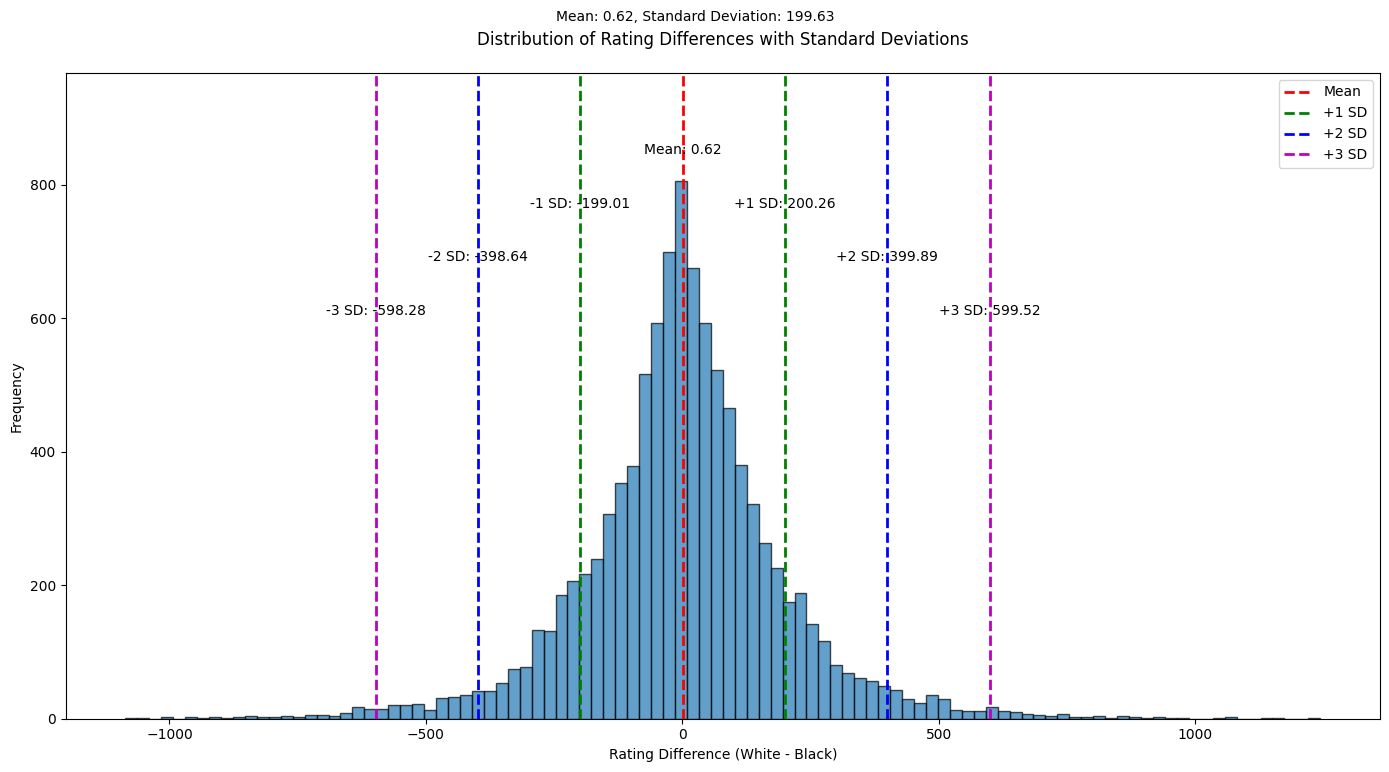

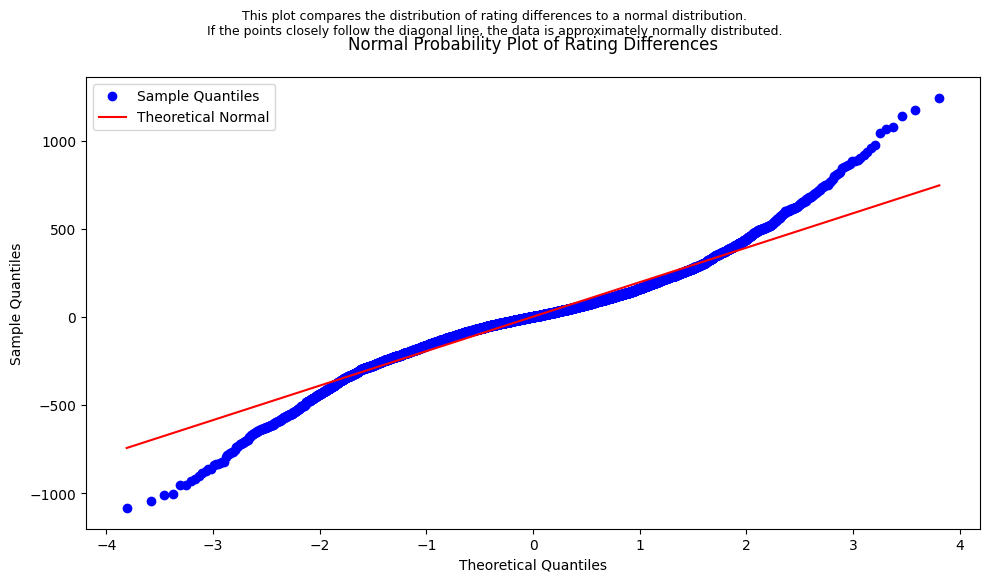

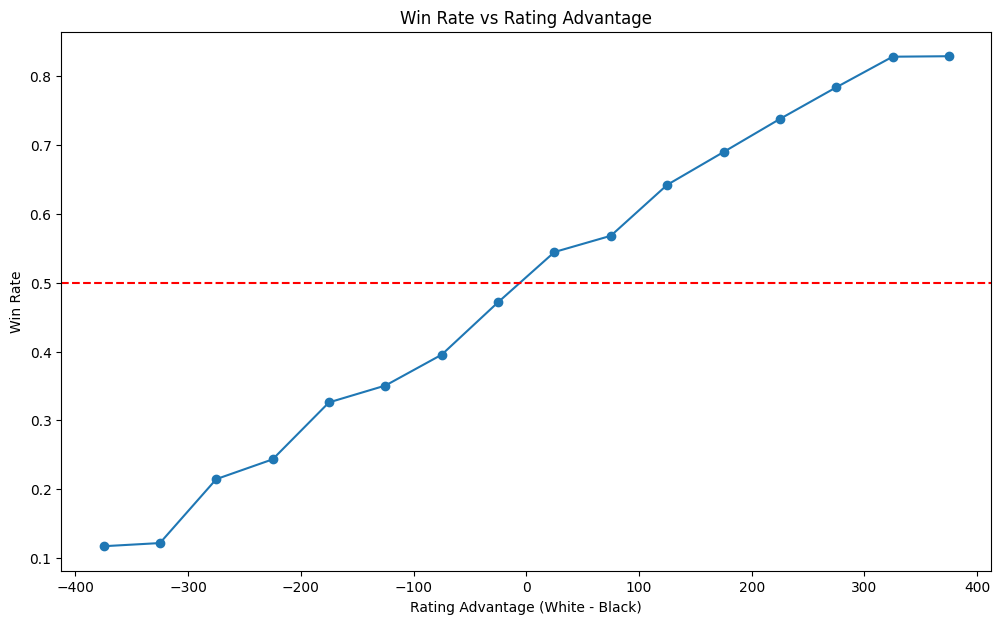

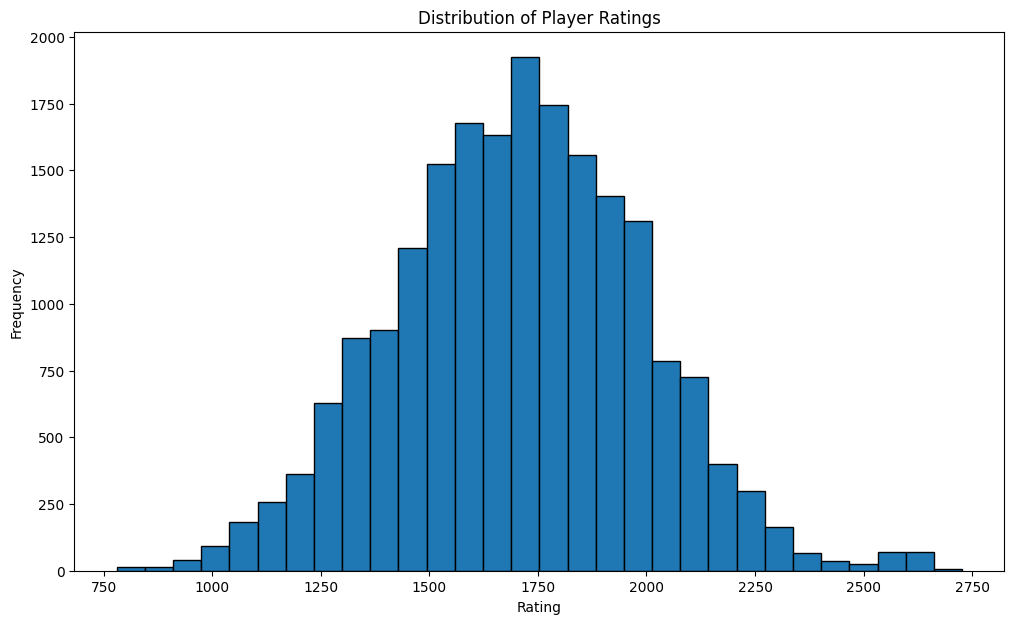

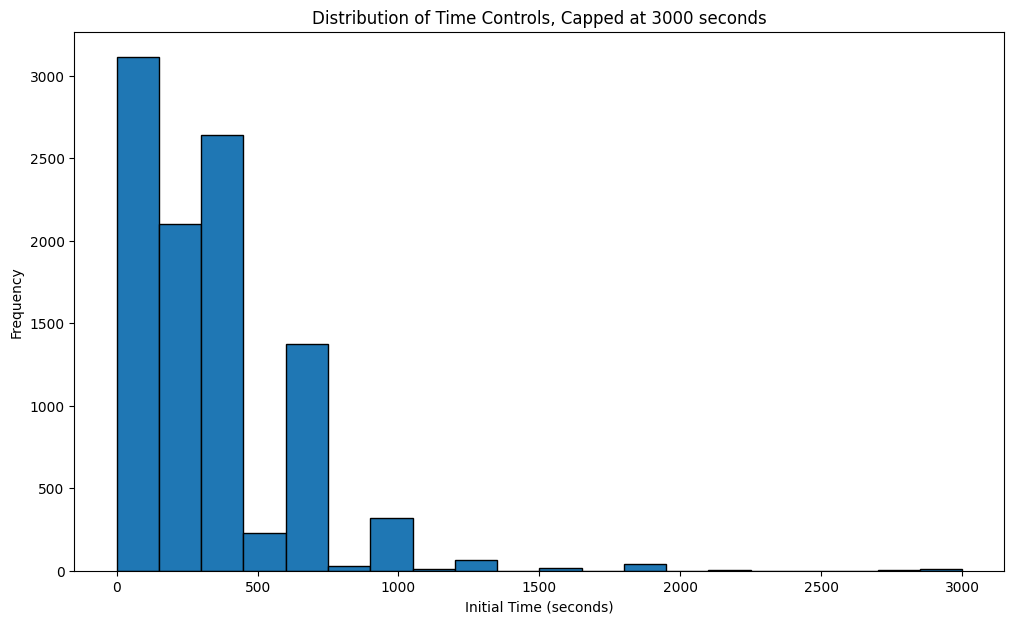

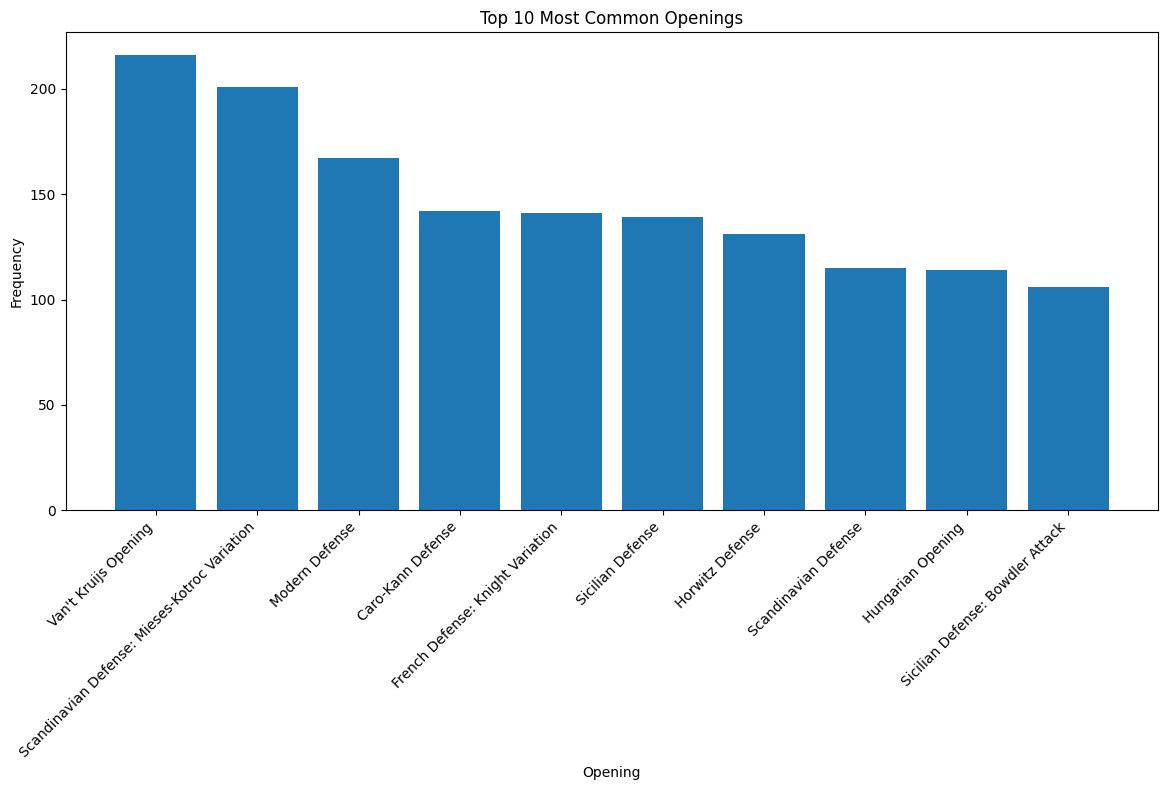

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


def plot_statistics(game_sts):
    # Check if game_stats is a dictionary
    if not isinstance(game_sts, dict):
        raise ValueError("Input must be a dictionary containing game statistics")

    durations_moves = game_sts['game_durations_moves']
    durations_time = game_sts['game_durations_time']
    rating_diffs = game_sts['rating_differences']

    # 1. Pie chart for game results
    plt.figure(figsize=(12, 7))
    results = [game_sts['white_wins'], game_sts['black_wins'], game_sts['ties']]
    labels = ['White Wins', 'Black Wins', 'Ties']
    colors = ['#D5D5D5', '#585858', 'yellow']
    plt.pie(results, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'Game Results (Total Games: {game_sts["total_games"]})')
    plt.axis('equal')
    plt.show()

    # 2. Histogram of game durations in moves
    plt.figure(figsize=(12, 7))
    plt.hist(durations_moves, bins=30, edgecolor='black')
    plt.title('Distribution of Game Durations (Moves)')
    plt.xlabel('Number of Moves')
    plt.ylabel('Frequency')
    plt.show()

    # 3. Histogram of game durations in time (if available)
    if durations_time:
        cap = 2500
        # cap time at 1 hour
        durations_time = [d if d < cap else cap for d in durations_time]

        plt.figure(figsize=(12, 7))
        plt.hist(durations_time, bins=30, edgecolor='black')
        plt.title(f'Distribution of Game Durations (Time) - Capped at {cap} seconds')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Frequency')
        plt.show()

    # 4. Histogram of rating differences
    plt.figure(figsize=(12, 7))
    plt.hist(rating_diffs, bins=30, edgecolor='black')
    plt.title('Distribution of Rating Differences (White - Black)')
    plt.xlabel('Rating Difference')
    plt.ylabel('Frequency')
    plt.show()

    # 7. Distribution of rating differences with mean and standard deviation lines
    plt.figure(figsize=(14, 8))
    rating_diffs = np.array(game_sts['rating_differences'])
    mean = np.mean(rating_diffs)
    std = np.std(rating_diffs)

    # Plot histogram
    counts, bins, _ = plt.hist(rating_diffs, bins=100, edgecolor='black', alpha=0.7)
    
    # Calculate the y-height for the lines
    y_height = max(counts)

    # Plot mean and standard deviation lines
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label='+1 SD')
    plt.axvline(mean - std, color='g', linestyle='dashed', linewidth=2)
    plt.axvline(mean + 2*std, color='b', linestyle='dashed', linewidth=2, label='+2 SD')
    plt.axvline(mean - 2*std, color='b', linestyle='dashed', linewidth=2)
    plt.axvline(mean + 3*std, color='m', linestyle='dashed', linewidth=2, label='+3 SD')
    plt.axvline(mean - 3*std, color='m', linestyle='dashed', linewidth=2)

    # Add text annotations
    plt.text(mean, y_height * 1.05, f'Mean: {mean:.2f}', horizontalalignment='center')
    plt.text(mean + std, y_height * 0.95, f'+1 SD: {mean+std:.2f}', horizontalalignment='center')
    plt.text(mean - std, y_height * 0.95, f'-1 SD: {mean-std:.2f}', horizontalalignment='center')
    plt.text(mean + 2*std, y_height * 0.85, f'+2 SD: {mean+2*std:.2f}', horizontalalignment='center')
    plt.text(mean - 2*std, y_height * 0.85, f'-2 SD: {mean-2*std:.2f}', horizontalalignment='center')
    plt.text(mean + 3*std, y_height * 0.75, f'+3 SD: {mean+3*std:.2f}', horizontalalignment='center')
    plt.text(mean - 3*std, y_height * 0.75, f'-3 SD: {mean-3*std:.2f}', horizontalalignment='center')

    plt.title('Distribution of Rating Differences with Standard Deviations', pad=20)
    plt.xlabel('Rating Difference (White - Black)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Adjust the plot to make room for annotations
    plt.ylim(0, y_height * 1.2)
    
    # Add subtitle below the main title
    plt.text(0.5, 0.95, f'Mean: {mean:.2f}, Standard Deviation: {std:.2f}', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gcf().transFigure, fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Adjust top margin to accommodate subtitle
    plt.show()

    # 8. Normal probability plot
    fig, ax = plt.subplots(figsize=(10, 6))
    (osm, osr), _ = stats.probplot(rating_diffs, dist="norm", plot=ax)
    
    # Add a legend
    ax.get_lines()[0].set_label('Sample Quantiles')
    ax.get_lines()[1].set_label('Theoretical Normal')
    ax.legend()

    plt.title("Normal Probability Plot of Rating Differences", pad=20)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    
    # Add subtitle explaining the plot
    subtitle = ("This plot compares the distribution of rating differences to a normal distribution.\n"
                "If the points closely follow the diagonal line, the data is approximately normally distributed.")
    plt.text(0.5, 0.94, subtitle, horizontalalignment='center', verticalalignment='center', 
             transform=plt.gcf().transFigure, fontsize=9, wrap=True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust top margin to accommodate subtitle
    plt.show()

    # 7. Win rate vs Rating Advantage
    rating_bins = np.arange(-400, 401, 50)
    win_rates = []
    for i in range(len(rating_bins) - 1):
        lower, upper = rating_bins[i], rating_bins[i + 1]
        games_in_range = [g for g, r in zip(game_sts['results'], game_sts['rating_differences']) if
                          lower <= r < upper]
        wins = games_in_range.count(1)
        win_rates.append(wins / len(games_in_range) if games_in_range else 0)

    plt.figure(figsize=(12, 7))
    plt.plot(rating_bins[:-1] + 25, win_rates, marker='o')
    plt.title('Win Rate vs Rating Advantage')
    plt.xlabel('Rating Advantage (White - Black)')
    plt.ylabel('Win Rate')
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.show()

    # 9. Rating distribution
    all_ratings = game_sts['white_ratings'] + game_sts['black_ratings']
    plt.figure(figsize=(12, 7))
    plt.hist(all_ratings, bins=30, edgecolor='black')
    plt.title('Distribution of Player Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

    # 10. Time control distribution (if available)
    if game_sts['time_controls']:
        cap = 3000
        time_controls = [tc.split('+')[0] for tc in game_sts['time_controls'] if '+' in tc]
        time_controls = [int(tc) for tc in time_controls if tc.isdigit()]
        time_controls = [tc if tc < cap else cap for tc in time_controls]
        plt.figure(figsize=(12, 7))
        plt.hist(time_controls, bins=20, edgecolor='black')
        plt.title(f'Distribution of Time Controls, Capped at {cap} seconds')
        plt.xlabel('Initial Time (seconds)')
        plt.ylabel('Frequency')
        plt.show()

    # 11. Top 10 most common openings
    plt.figure(figsize=(12, 8))
    openings = game_sts.get('openings', {})
    top_openings = dict(sorted(openings.items(), key=lambda x: x[1], reverse=True)[:10])
    plt.bar(top_openings.keys(), top_openings.values())
    plt.title('Top 10 Most Common Openings')
    plt.xlabel('Opening')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_statistics(game_sts)
